In [ ]:
%%bash
pip install tensorflow==2.14
pip install tensorflow-probability==0.22
pip install tensorflow-compression~=2.14

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 86.0 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling t

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.14.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine ==

# Definition of the training model

We'll consider an auto-encoder model consisting of three parts:
* the analysis transform (or encoder), which converts the image into a vector in a latent space
space,
* the synthesis transform (or decoder), which converts the vector from latent space into
image space, and
* a model for the a priori marginal probability distributions of latent vectors, useful for
for calculating entropy.


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

In [ ]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""
  return tf.keras.Sequential([
      tf.keras.layers.Conv2D(20, 5, use_bias=True, strides=2, padding="same",activation="leaky_relu", name="conv_1"),
      tf.keras.layers.Conv2D(50, 5, use_bias=True, strides=2, padding="same",activation="leaky_relu", name="conv_2"),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(500, use_bias=True, activation="leaky_relu", name="fc_1"),
      tf.keras.layers.Dense(latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")

In [ ]:
def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""
  return tf.keras.Sequential([
  tf.keras.layers.Dense(
  500, use_bias=True, activation="leaky_relu", name="fc_1"),
  tf.keras.layers.Dense(
  2450, use_bias=True, activation="leaky_relu", name="fc_2"),
  tf.keras.layers.Reshape((7, 7, 50)),
  tf.keras.layers.Conv2DTranspose(
  20, 5, use_bias=True, strides=2, padding="same",
  activation="leaky_relu", name="conv_1"),
  tf.keras.layers.Conv2DTranspose(
  1, 5, use_bias=True, strides=2, padding="same",
  activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")

In [ ]:
class MNISTCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    x = tf.reshape(x, (-1, 28, 28, 1))
    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(
    self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)
    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)
    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x - x_tilde))
    return dict(rate=rate, distortion=distortion)

# Calculation of rate and distortion

In [ ]:
training_dataset, validation_dataset = tfds.load(
  "mnist",
  split=["train", "test"],
  shuffle_files=True,
  as_supervised=True,
  with_info=False,
)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
len(training_dataset)

60000

In [ ]:
len(validation_dataset)

10000

Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


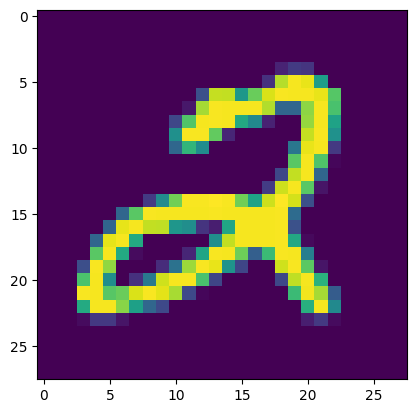

In [ ]:
(x, _), = validation_dataset.take(1)
plt.imshow(tf.squeeze(x))
print(f"Data type: {x.dtype}")
print(f"Shape: {x.shape}")

To obtain the latent representation y, we need to convert x to float32, add a dimension to enable batch processing and pass it through the analysis transformation.

In [ ]:
x = tf.cast(x, tf.float32) / 255.
x = tf.reshape(x, (-1, 28, 28, 1))
y = make_analysis_transform(10)(x)

In [ ]:
type(y)

tensorflow.python.framework.ops.EagerTensor

In [ ]:
y_tilde = y + tf.random.uniform(y.shape, -.5, .5)

In [ ]:
prior = tfc.NoisyLogistic(loc=0., scale=tf.linspace(.01, 2., 10))


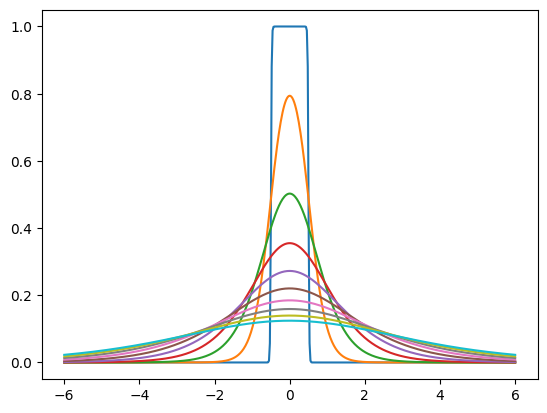

In [ ]:
_ = tf.linspace(-6., 6., 501)[:, None]
plt.plot(_, prior.prob(_));

In [ ]:
entropy_model = tfc.ContinuousBatchedEntropyModel(
prior, coding_rank=1, compression=False)
y_tilde, rate = entropy_model(y, training=True)

In [ ]:
print(float(rate))

18.52911949157715


distortion: tf.Tensor(0.17104103, shape=(), dtype=float32)
Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


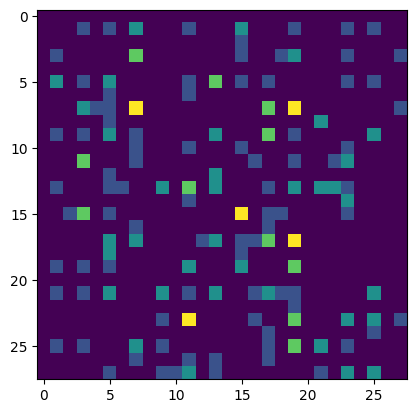

In [ ]:
x_tilde = make_synthesis_transform()(y_tilde)
# Mean absolute difference across pixels.
distortion = tf.reduce_mean(abs(x - x_tilde))
print("distortion:", distortion)
x_tilde = tf.saturate_cast(x_tilde[0] * 255, tf.uint8)
plt.imshow(tf.squeeze(x_tilde))
print(f"Data type: {x_tilde.dtype}")
print(f"Shape: {x_tilde.shape}")


In [ ]:
(example_batch, _), = validation_dataset.batch(32).take(1)
trainer = MNISTCompressionTrainer(10)
example_output = trainer(example_batch)
print("rate: ", round(float(example_output["rate"]), 2))
print("distortion: ", round(float(example_output["distortion"]), 2))

rate:  20.3
distortion:  0.15


## Model training



In [ ]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_mnist_compression_trainer(lmbda, latent_dims=50):
  trainer = MNISTCompressionTrainer(latent_dims)
  trainer.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
  # Just pass through rate and distortion as losses/metrics.
  loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
  metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
  loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer


In [ ]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_mnist_model(lmbda):
  trainer = make_mnist_compression_trainer(lmbda)
  trainer.fit(
  training_dataset.map(add_rd_targets).batch(128).prefetch(8),
  epochs=5,
  validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
  validation_freq=1,
  verbose=1,
  )
  return trainer

In [ ]:
trainer = train_mnist_model(lmbda=2000)

Epoch 1/5
469/469 [==============================] - ETA: 0s - loss: 218.5346 - distortion_loss: 0.0593 - rate_loss: 99.9968 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 99.9923  

469/469 [==============================] - 23s 43ms/step - loss: 218.5346 - distortion_loss: 0.0593 - rate_loss: 99.9968 - distortion_pass_through_loss: 0.0593 - rate_pass_through_loss: 99.9923 - val_loss: 178.4383 - val_distortion_loss: 0.0432 - val_rate_loss: 92.1372 - val_distortion_pass_through_loss: 0.0432 - val_rate_pass_through_loss: 92.1390
Epoch 2/5
469/469 [==============================] - 19s 40ms/step - loss: 165.9025 - distortion_loss: 0.0410 - rate_loss: 83.9158 - distortion_pass_through_loss: 0.0410 - rate_pass_through_loss: 83.9113 - val_loss: 156.4948 - val_distortion_loss: 0.0399 - val_rate_loss: 76.7382 - val_distortion_pass_through_loss: 0.0399 - val_rate_pass_through_loss: 76.7446
Epoch 3/5
469/469 [==============================] - 18s 39ms/step - loss: 150.9258 - distortion_loss: 0.0399 - rate_loss: 71.1688 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 71.1658 - val_loss: 144.7651 - val_distortion_loss: 0.0406 - val_rate_loss: 63.6302 - val_di

# Compress images from MNIST dataset


In [ ]:
class MNISTCompressor(tf.keras.Model):
  """Compresses MNIST images to strings."""
  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits


In [ ]:
class MNISTDecompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""
  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

In [ ]:
def make_mnist_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
  trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = MNISTCompressor(trainer.analysis_transform, entropy_model)
  decompressor = MNISTDecompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor
  compressor, decompressor = make_mnist_codec(trainer)

In [ ]:
compressor, decompressor = make_mnist_codec(trainer)

Batch of 16 images for the validation dataset

In [ ]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)

In [ ]:
strings, entropies = compressor(originals)

print(f"String representation of digit in hex: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")


String representation of digit in hex: 0x63f4f5e13ec2
Number of bits actually needed to represent it: 47.28


In [ ]:
reconstructions = decompressor(strings)

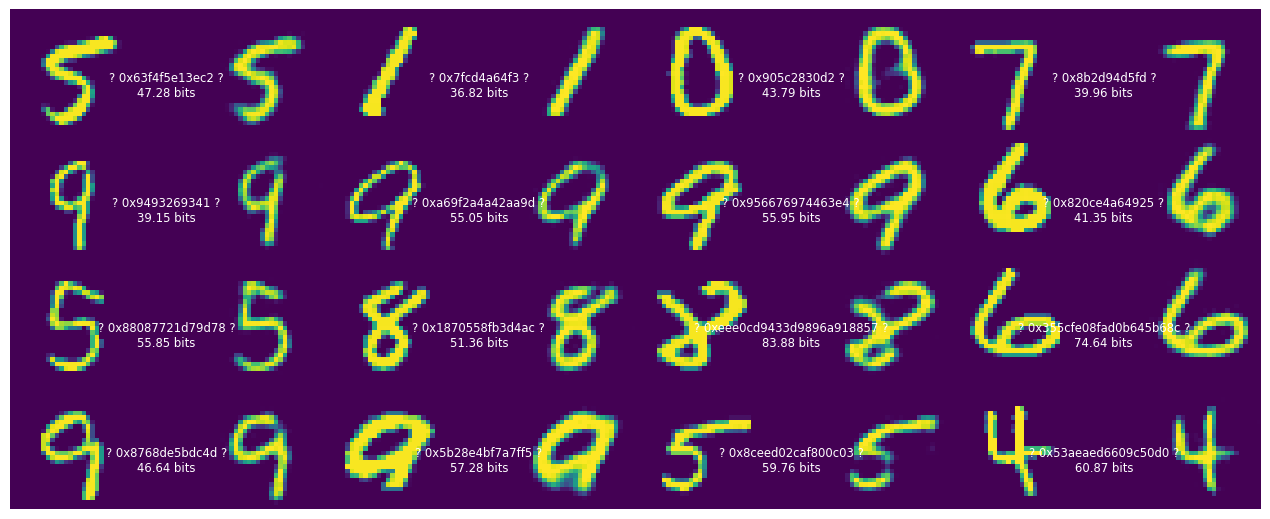

In [ ]:
def display_digits(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""
  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):
    image = tf.concat([
      tf.squeeze(originals[i]),
      tf.zeros((28, 14), tf.uint8),
      tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
    .5, .5, f"? 0x{strings[i].numpy().hex()} ?\n{entropies[i]:0.2f} bits",
    ha="center", va="top", color="white", fontsize="small",
    transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
display_digits(originals, strings, entropies, reconstructions)


In [ ]:
import numpy as np

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

In [ ]:
def display_digits(originals, strings, entropies, reconstructions):
    fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
    axes = axes.ravel()
    for i in range(len(axes)):
        image = tf.concat([
            tf.squeeze(originals[i]),
            tf.zeros((28, 14), tf.uint8),
            tf.squeeze(reconstructions[i]),
        ], 1)
        psnr = calculate_psnr(originals[i].numpy(), reconstructions[i].numpy())
        axes[i].imshow(image)
        axes[i].text(
        .5, .5, f"> 0x{strings[i].numpy().hex()} >\n{entropies[i]:0.2f} bits\nPSNR: {psnr:.2f} dB",
        ha="center", va="top", color="white", fontsize="small",
        transform=axes[i].transAxes)
        axes[i].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)


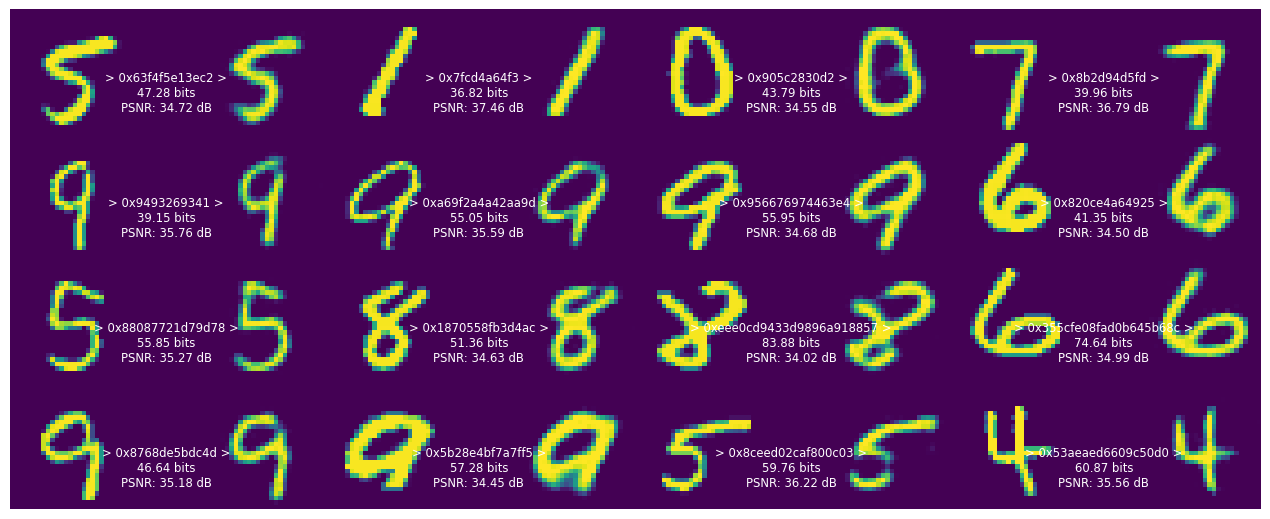

In [ ]:
display_digits(originals, strings, entropies, reconstructions)

:# Trade-off rate/distortion

In [ ]:
def train_and_visualize_model(lmbda):
  trainer = train_mnist_model(lmbda=lmbda)
  compressor, decompressor = make_mnist_codec(trainer)
  strings, entropies = compressor(originals)
  reconstructions = decompressor(strings)
  display_digits(originals, strings, entropies, reconstructions)


In [ ]:
def calculate_mean_rate_psnr(compressorX, decompressorX) :
  """Return mean rate and mean psnr"""
  (originals, _), = validation_dataset.batch(16).skip(3).take(1)
  strings, entropies = compressorX(originals)
  reconstructions = decompressorX(strings)

  rate_list = list()
  psnr_list = list()
  for ori, rate, rec in zip(originals, entropies, reconstructions) :
    rate_list.append(rate)
    psnr_list.append(calculate_psnr(ori.numpy(), rec.numpy()))

  return round(float(sum(rate_list)/len(rate_list)), 3), round(float(sum(psnr_list)/len(psnr_list)), 3)

In [ ]:
def train_mnist_model(lmbda):
  trainer = make_mnist_compression_trainer(lmbda)
  trainer.fit(
  training_dataset.map(add_rd_targets).batch(128).prefetch(8),
  epochs=5,
  validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
  validation_freq=1,
  verbose=1,
  )
  return trainer

# Decoder as a generativ model

In [ ]:
compressor, decompressor = make_mnist_codec(trainer, decode_sanity_check=False)

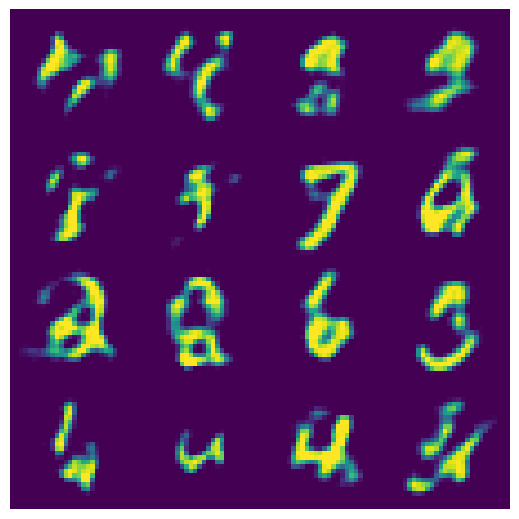

In [ ]:
import os
strings = tf.constant([os.urandom(8) for _ in range(16)])

samples = decompressor(strings)
fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.ravel()
for i in range(len(axes)):
  axes[i].imshow(tf.squeeze(samples[i]))
  axes[i].axis("off")
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)